In [175]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab
from torchlake.text_generation.controller.trainer_show_attend_tell import ShowAttendTellTrainer
from torchlake.text_generation.datasets.flickr import Flickr8k, Flickr8kFromLMDB
from torchlake.text_generation.models.show_attend_tell import ShowAttendTell, SoftAttention, HardAttention, DoublyStochasticAttentionLoss
from torchlake.sequence_data.models.base import RNNGenerator
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchtext.data.utils import get_tokenizer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.controller.recorder import TrainRecorder
import torchtext.transforms as T
from tqdm import tqdm
from pathlib import Path

To utilize this notebook, you have to install `spacy` and download `de_core_news_sm` and `en_core_web_sm` first

# setting

In [176]:
data_path = Path("F://data/flickr8k")
data_path.mkdir(exist_ok=True)

artifacts_path = Path("../../artifacts/show-and-attend-tell")
artifacts_path.mkdir(exist_ok=True)

In [177]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 32
CONTEXT = NlpContext(max_seq_len=MAX_SEQ_LEN)

In [178]:
DEVICE = torch.device(CONTEXT.device)

# data

In [179]:
tokenizer = get_tokenizer('spacy', language='en')  # en_web_core_sm

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [180]:
IMAGE_SIZE = 224

In [181]:
image_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # extractor will do imagenet normalization, so skip it here
        A.Normalize(0, 1), 
        ToTensorV2(),
    ]
)

In [182]:
# only keep for remind me of how to use official dataset

# import joblib
# from torchvision.datasets import Flickr8k

# cache_path =  Path("./cache")

# if cache_path.exists():
#     train_iter = joblib.load(cache_path.as_posix())
# else:      
#     # sloooooooooooooooow
#     train_iter = Flickr8k(
#         data_path.joinpath("Images"),
#         data_path.joinpath("8k-pictures.html"),
#         transform=image_transform,
#     )
#     joblib.dump(train_iter, cache_path.as_posix())  

In [183]:
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
# )

In [184]:
# for i, (img, text) in enumerate(train_iter):
#     print(img.shape, text)
    
#     if i > 5:
#         break

In [185]:
# train_iter.annotations

In [186]:
# create lmdb one
# import lmdb

# env = lmdb.Environment(
#     data_path.joinpath("flickr8k").as_posix(),
#     map_size=1<<33, # 8GB
# )
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
# )

# train_iter.to_lmdb(env)

In [187]:
# env.close()

In [188]:
train_iter = Flickr8kFromLMDB(
    data_path.joinpath("flickr8k").as_posix(),
)

(array([1.700e+01, 4.600e+01, 2.370e+02, 1.843e+03, 2.683e+03, 3.397e+03,
        8.101e+03, 4.342e+03, 4.070e+03, 3.639e+03, 5.545e+03, 1.830e+03,
        1.372e+03, 1.736e+03, 5.100e+02, 3.430e+02, 3.770e+02, 1.240e+02,
        7.600e+01, 6.000e+01, 5.700e+01, 1.100e+01, 1.000e+01, 1.900e+01,
        2.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ,
        16.3, 17.6, 18.9, 20.2, 21.5, 22.8, 24.1, 25.4, 26.7, 28. , 29.3,
        30.6, 31.9, 33.2, 34.5, 35.8, 37.1, 38.4, 39.7, 41. ]),
 <BarContainer object of 30 artists>)

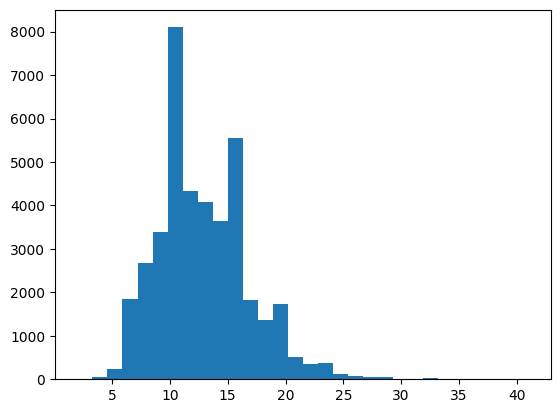

In [189]:
sentence_lengths = [len(tokenizer(text)) for _, text in train_iter]
plt.hist(sentence_lengths, bins=30)

In [190]:
vocab = build_vocab(
    map(lambda pair: tokenizer(pair[1].lower().strip()), train_iter),
    CONTEXT,
)

In [191]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

3102

In [192]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [193]:
def text_pipeline(corpus: str) -> list[torch.Tensor]:
    x = corpus.lower().strip()
    x = tokenizer(x)
    x = text_transform(x)
    return x

In [194]:
train_iter.env.close()

In [195]:
# 1GB
# train_iter = Flickr8k(
#     data_path.joinpath("Images"),
#     data_path.joinpath("captions.txt"),
#     image_transform,
#     text_pipeline,
# )

In [196]:
train_iter = Flickr8kFromLMDB(
    data_path.joinpath("flickr8k").as_posix(),
    image_transform,
    text_pipeline,
)

In [197]:
for imgs, caption in train_iter:
    print(imgs.shape, caption.shape)
    break

torch.Size([3, 224, 224]) torch.Size([32])


In [198]:
# def collate_fn(batch):
#     image_batch, label_batch = [], []

#     for x, y in batch:
#         y = text_pipeline(y)
#         for yi in y:
#             image_batch.append(x)
#             label_batch.append(yi)

#     return torch.stack(image_batch), torch.stack(label_batch)

In [199]:
NUM_WORKERS = get_num_workers()

In [200]:
train_loader = DataLoader(
    train_iter,
    batch_size=BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)

# test_loader = DataLoader(
#     val_iter,
#     batch_size=BATCH_SIZE,
#     collate_fn=collate_fn,
#     num_workers=NUM_WORKERS,
    # pin_memory=True,
# )

In [201]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128, 32])


# Model

In [202]:
from functools import partial

In [203]:
from torchlake.common.models import VGGFeatureExtractor

extractor = VGGFeatureExtractor("vgg16", "relu", trainable=False)
extractor.forward = partial(extractor.forward, target_layer_names=["5_3"])

In [204]:
# from torchlake.common.models import ResNetFeatureExtractor

# extractor = ResNetFeatureExtractor("resnet50", "block", trainable=False)
# extractor.forward = partial(extractor.forward, target_layer_names=["4_1"])

In [205]:
# attention = SoftAttention(512, 256, True)

attention = HardAttention(512, 256, True)

In [206]:
decoder = RNNGenerator(
    model=LSTMDiscriminator(
        VOCAB_SIZE,
        embed_dim=512,
        hidden_dim=256,
        output_size=VOCAB_SIZE,
        num_layers=2,
        context_dim=512,
        bidirectional=True,
        context=CONTEXT,
    ),
    attention=attention,
)

In [207]:
model = ShowAttendTell(
    extractor,
    decoder,
    context=CONTEXT,
    # encode_dim=512,  # use it when feature extractor work on layers other than last one 
).to(DEVICE)

In [208]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
ShowAttendTell                                --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

# Training

In [35]:
EPOCHS = 10

In [36]:
trainer = ShowAttendTellTrainer(EPOCHS, DEVICE, feature_last=True)
trainer.set_curriculum_strategy("inverse_sigmoid", k=5)

In [37]:
criterion = DoublyStochasticAttentionLoss(ignore_index=CONTEXT.padding_idx, reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
recorder = TrainRecorder(total_epoch=EPOCHS)
recorder.increment_data_size(len(train_iter))

In [39]:
recorder.data_size

40455

In [40]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [41]:
scaler = torch.amp.grad_scaler.GradScaler()

In [42]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    recorder=recorder,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 317/317 [02:37<00:00,  2.01it/s]


Epoch 1 : 52.81111136155817 (0%)


100%|██████████| 317/317 [02:32<00:00,  2.07it/s]


Epoch 2 : 40.54171214355349 (-23%)


100%|██████████| 317/317 [02:32<00:00,  2.08it/s]


Epoch 3 : 37.22631100136102 (-8%)


100%|██████████| 317/317 [02:33<00:00,  2.06it/s]


Epoch 4 : 35.17179769144236 (-6%)


100%|██████████| 317/317 [02:31<00:00,  2.09it/s]


Epoch 5 : 33.62823754842077 (-4%)


100%|██████████| 317/317 [02:33<00:00,  2.07it/s]


Epoch 6 : 32.360432257750695 (-4%)


100%|██████████| 317/317 [02:31<00:00,  2.09it/s]


Epoch 7 : 31.232756569588542 (-3%)


100%|██████████| 317/317 [02:31<00:00,  2.09it/s]


Epoch 8 : 30.176758084069107 (-3%)


100%|██████████| 317/317 [02:31<00:00,  2.09it/s]


Epoch 9 : 29.170922395552715 (-3%)


100%|██████████| 317/317 [02:32<00:00,  2.08it/s]

Epoch 10 : 28.28857266288534 (-3%)


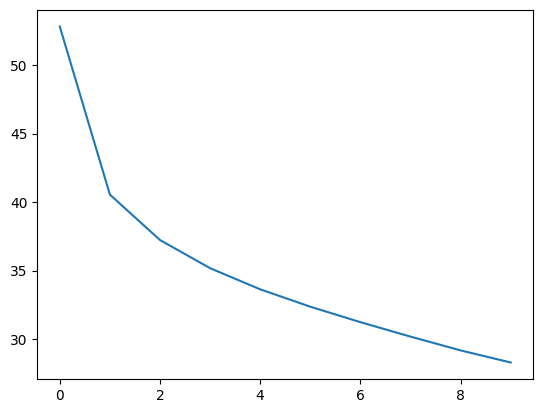

In [43]:
plt.plot(training_loss)

# Save

In [209]:
wm = WeightManager(artifacts_path.joinpath("show-attend-tell.vgg16.{attention}.{num_layer}.pth").as_posix())

In [210]:
attention_prefix = "soft" if isinstance(attention, SoftAttention) else "hard"

model_path = wm.get_filename(
    attention=attention_prefix,
    num_layer=model.head.head.num_layers,
)
model_path

WindowsPath('../../artifacts/show-and-attend-tell/show-attend-tell.vgg16.hard.2.pth')

In [46]:
wm.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\show-and-attend-tell\show-attend-tell.vgg16.hard.2.pth, model size is 86.32MiB


In [211]:
wm.load_weight(model_path, model)

# Evaluate

## BLEU score

In [125]:
VAL_BATCH_SIZE = 125

In [126]:
val_loader = DataLoader(
    train_iter,
    batch_size=VAL_BATCH_SIZE,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

In [127]:
from torchmetrics.text import BLEUScore

In [128]:
metric = BLEUScore()

In [130]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for imgs, captions in tqdm(val_loader):
        gts = [[] for _ in range(imgs.size(0) // 5)]
        data_count += len(imgs)

        # list of strings
        # i.e. list of candidates
        for i, t in enumerate(captions.tolist()):
            caption = vocab.lookup_tokens(t)
            try:
                start_idx, end_idx = caption.index(CONTEXT.bos_str), caption.index(
                    CONTEXT.eos_str
                )
            except:
                start_idx, end_idx = 0, -1
            gts[i // 5].append(" ".join(caption[start_idx + 1 : end_idx]))

        # if data_count % 5 == 0:
        imgs = imgs.to(DEVICE)
        outputs = model.predict(imgs, topk=1)

        # list of string
        preds = []
        for o in outputs[::5].tolist():
            output = vocab.lookup_tokens(o)
            try:
                start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(
                    CONTEXT.eos_str
                )
            except:
                start_idx, end_idx = 0, -1
            preds.append(" ".join(output[start_idx + 1 : end_idx]))

        assert len(gts) == imgs.size(0) // 5
        assert len(preds) == imgs.size(0) // 5

        metric.update(preds, gts)

        # if data_count >= 5:
        #     break

100%|██████████| 324/324 [02:35<00:00,  2.08it/s]


In [131]:
metric.compute()

tensor(0.3319)

## Compare to groundtruth

In [86]:
from torchlake.common.utils.convert import img_tensor_to_np

CLIP = 5

imgs = []
titles = []
model.eval()
with torch.no_grad():
    for i, (img_batch, text_batch) in enumerate(train_loader):
        img_batch = img_batch.to(DEVICE)
        imgs = img_tensor_to_np(img_batch[:CLIP])
        
        outputs = model.predict(img_batch, topk=1)
        
        for j in range(CLIP):
            output = outputs[j].tolist()
            output = vocab.lookup_tokens(output)
            start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(CONTEXT.eos_str)
            output_tokens = output[start_idx+1:end_idx]
            
            target = text_batch[j].tolist()
            target_tokens = vocab.lookup_tokens(target)
            target_start_idx, target_end_idx = target_tokens.index(CONTEXT.bos_str), target_tokens.index(CONTEXT.eos_str)
            target_tokens = target_tokens[target_start_idx+1:target_end_idx]
            
            # collect tokens
            titles.append(" ".join(output_tokens))
            
            print(f'第{j+1}句')
            print('target:', *target_tokens, sep=' ')
            print('output:', *output_tokens, sep=' ')
        
        # if i+1==CLIP: break
        break

第1句
target: b'a <unk> man with his back to the camera is overlooking the water . '
output: b'a man in a black shirt is standing on a rock . '
第2句
target: b'two girls play in a sand box . '
output: b'a little girl in a pink shirt is sitting on a blue chair with a little girl in the background . '
第3句
target: b'a dog leaps while chasing a tennis ball through a grassy field . '
output: b'a dog leaps to catch a ball . '
第4句
target: b'a snowboarder is jumping over a snowy hill '
output: b'a man is snowboarding down a snowy hill . '
第5句
target: b'a football player prepares to throw the ball . '
output: b'a football player in a white uniform is running with the ball . '


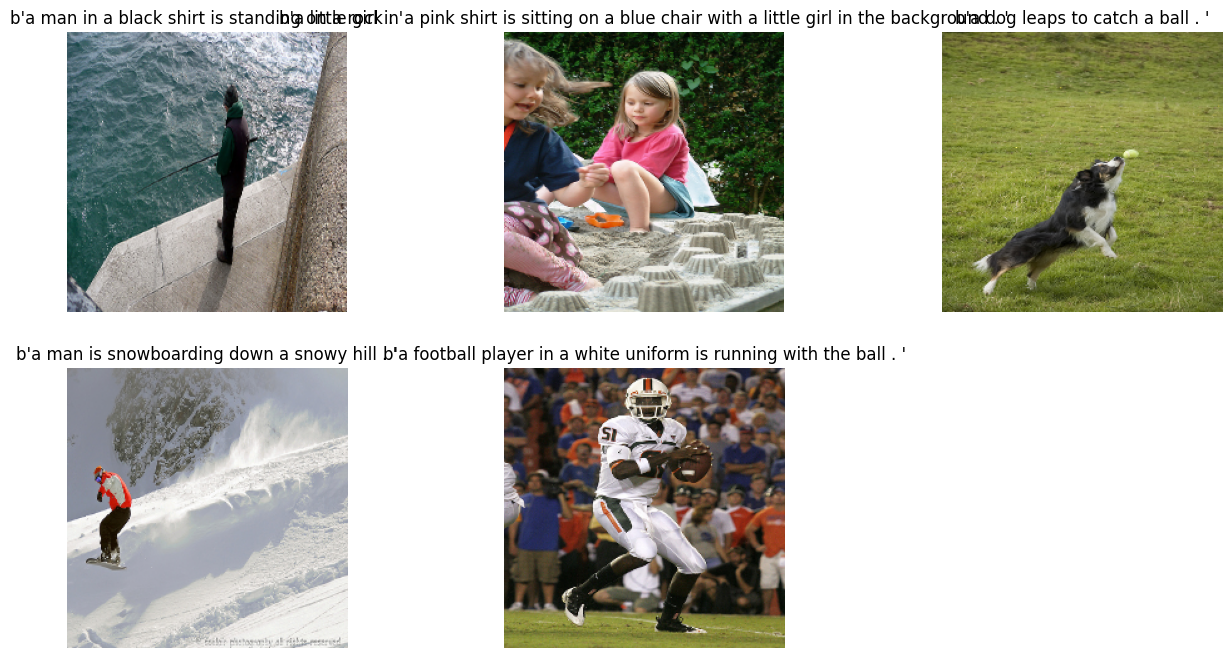

In [87]:
from torchlake.common.utils.plot import plot_grids

plot_grids(
    imgs,
    titles,
    num_row=2,
    num_col=3,
    figsize=(16, 8),
)

## In the wild

In [73]:
from torchlake.common.utils.image import load_image

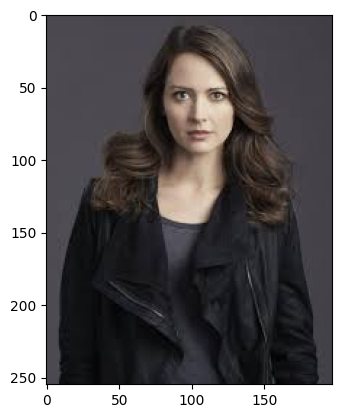

In [74]:
imgs = load_image("../../data/contents/black-woman.jpg", is_numpy=True)
plt.imshow(imgs)

In [83]:
model.eval()
with torch.no_grad():
    t_img = image_transform(image=imgs)["image"]
    t_img = t_img.unsqueeze(0).to(DEVICE)
    
    caption = model(t_img, topk=1)

In [84]:
output = vocab.lookup_tokens(caption[0].tolist())
end_index = output.index(CONTEXT.eos_str)

print(*output[1:end_index], sep=" ")

b'a woman in a black jacket and a woman in a black jacket . '


# attention visualization

In [213]:
from torchlake.common.utils.convert import img_tensor_to_np

CLIP = 5

imgs = []
titles = []
model.eval()
with torch.no_grad():
    for i, (img_batch, text_batch) in enumerate(train_loader):
        
        img_batch = img_batch.to(DEVICE)[:CLIP]
        outputs, atts = model.predict(img_batch, topk=1, output_score=True)
        
        imgs = img_tensor_to_np(img_batch)
        for j in range(CLIP):
            output = outputs[j].tolist()
            output = vocab.lookup_tokens(output)
            start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(CONTEXT.eos_str)
            output_tokens = output[start_idx+1:end_idx]
            
            target = text_batch[j].tolist()
            target_tokens = vocab.lookup_tokens(target)
            target_start_idx, target_end_idx = target_tokens.index(CONTEXT.bos_str), target_tokens.index(CONTEXT.eos_str)
            target_tokens = target_tokens[target_start_idx+1:target_end_idx]
            
            # collect tokens
            titles.append(" ".join(output_tokens))
            
            print(f'第{j+1}句')
            print('target:', *target_tokens, sep=' ')
            print('output:', *output_tokens, sep=' ')
        
        # if i+1==CLIP: break
        break

第1句
target: b'the white dog has a grey frisbee in its mouth . '
output: b'a white dog is jumping up to catch a frisbee . '
第2句
target: b'boy <unk> mud at girl '
output: b'a boy and a girl are playing in the sand . '
第3句
target: b'a man climbs a mountain . '
output: b'a man is climbing up a rock face . '
第4句
target: b'a girl catches a baseball . '
output: b'a man in a yellow shirt is swinging a bat on a stick . '
第5句
target: b'five people sitting down . '
output: b'a man in a white shirt and hat is holding a camera . '


In [ ]:
from torchlake.common.utils.image import overlay_image
import torch.nn.functional as F
import numpy as np

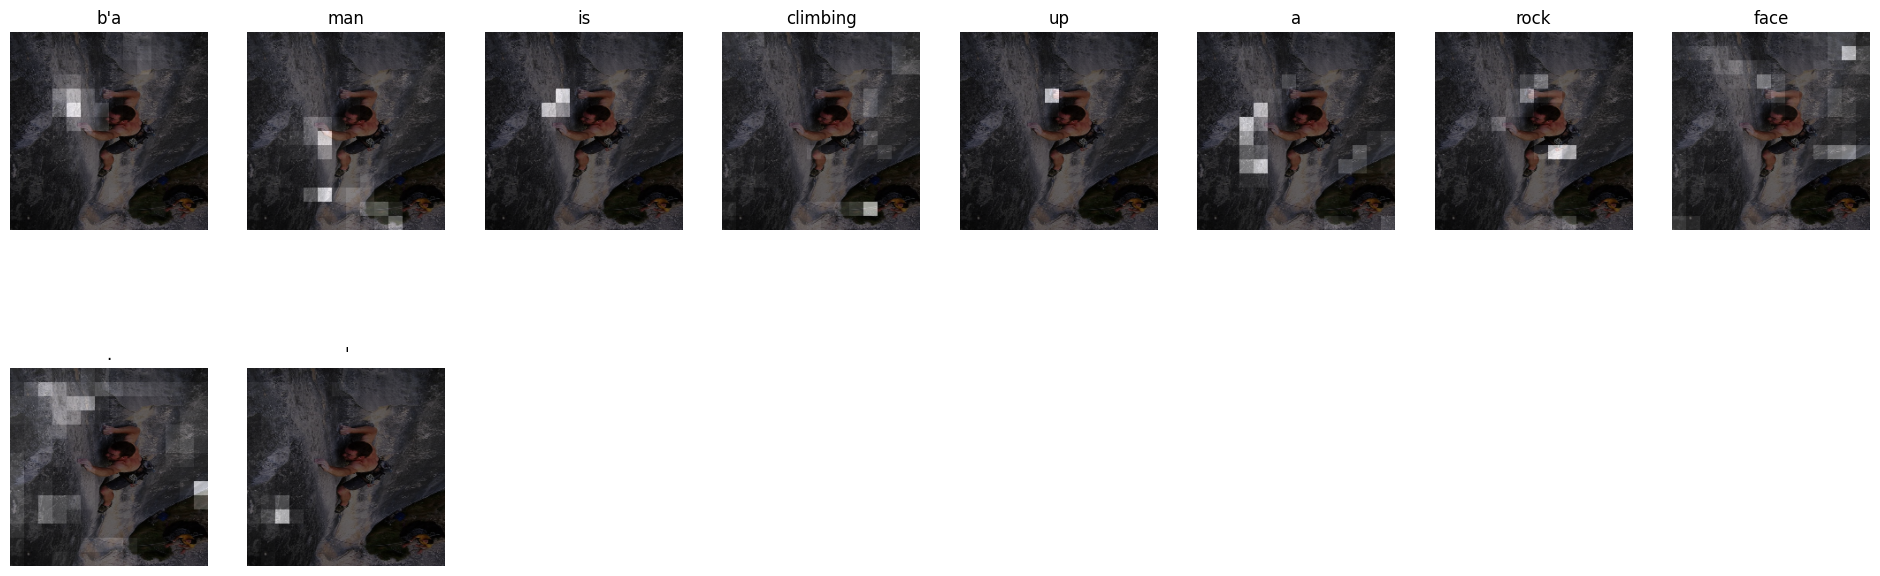

In [217]:
i = 2

output = outputs[i].tolist()
output = vocab.lookup_tokens(output)
start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(CONTEXT.eos_str)
output_tokens = output[start_idx+1:end_idx]

covers: np.ndarray = F.interpolate(
    atts[i].T.reshape(MAX_SEQ_LEN, 1, IMAGE_SIZE // 16, IMAGE_SIZE // 16),
    scale_factor=16,
).permute(0, 2, 3, 1).repeat(1, 1, 1, 3).cpu().numpy()
covers = (covers - covers.min((1, 2), keepdims=True)) / (covers.max((1, 2), keepdims=True) - covers.min((1, 2), keepdims=True))

new_imgs = [overlay_image(imgs[i], covers[j], 0.6) for j in range(start_idx+1, end_idx)]
            
plot_grids(
    new_imgs,
    output_tokens,
    num_col= min(len(new_imgs), 8),
    num_row= len(new_imgs) // 8 if len(new_imgs) % 8 == 0 else len(new_imgs) // 8 + 1,
    figsize=(24, 8),
)

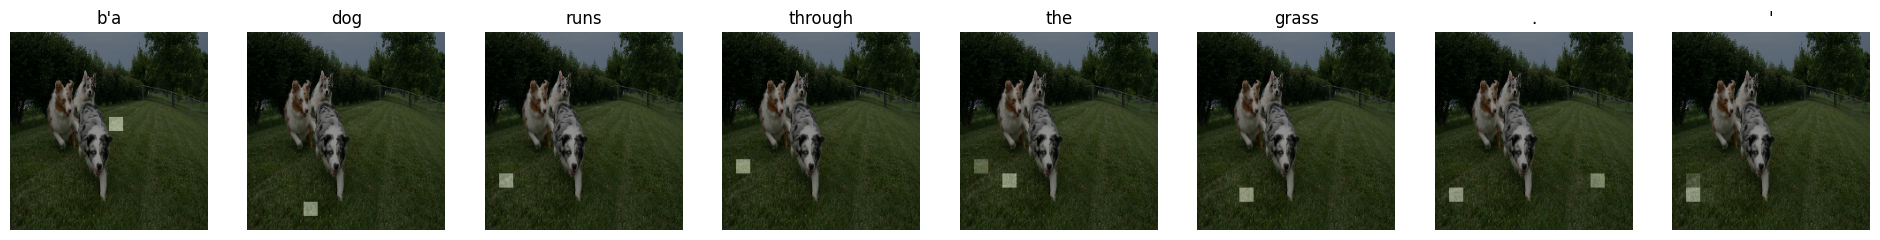

In [174]:
i = 4

output = outputs[i].tolist()
output = vocab.lookup_tokens(output)
start_idx, end_idx = output.index(CONTEXT.bos_str), output.index(CONTEXT.eos_str)
output_tokens = output[start_idx+1:end_idx]

covers: np.ndarray = F.interpolate(
    atts[i].T.reshape(MAX_SEQ_LEN, 1, IMAGE_SIZE // 16, IMAGE_SIZE // 16),
    scale_factor=16,
).permute(0, 2, 3, 1).repeat(1, 1, 1, 3).cpu().numpy()
covers = (covers - covers.min((1, 2), keepdims=True)) / (covers.max((1, 2), keepdims=True) - covers.min((1, 2), keepdims=True))

new_imgs = [overlay_image(imgs[i], covers[j], 0.4) for j in range(start_idx+1, end_idx)]
            
plot_grids(
    new_imgs,
    output_tokens,
    num_col= min(len(new_imgs), 8),
    num_row= len(new_imgs) // 8 if len(new_imgs) % 8 == 0 else len(new_imgs) // 8 + 1,
    figsize=(24, 8),
)